# Developing YOLO model for Recycalable Object Identification 

Installing and importing dependencies...

The EDA below was created while loosely following a tutorial for YOLOv5 from https://blog.paperspace.com/train-yolov5-custom-data/

In [ ]:
!pip install python-dotenv
!pip install kaggle

In [ ]:
from google.colab import drive
from pathlib import Path
import subprocess
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path 
from dotenv import load_dotenv
load_dotenv()
from src.utils import download_data_file, KaggleDownloader
import yaml
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

random.seed(108)
%load_ext autoreload
%autoreload 2

Check to see that torch is utilizing CUDA 

In [ ]:
print("Torch version: ", torch.__version__, '\n')
print("NVIDIA device specs: ", '\n')
!nvcc --version
print("\n Number of torch usable devices: ", torch.cuda.device_count())

Torch version:  1.9.0+cu111 

NVIDIA device specs:  

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0

 Number of torch usable devices:  1


### Dowload drinking waste and general waste classificaiton data

In [ ]:
download_data_file(
    url="arkadiyhacks/drinking-waste-classification",
    dest="./waste_data",
    clz=KaggleDownloader,
    extract=True
)

Using KaggleDownloader to download arkadiyhacks/drinking-waste-classification to ./waste_data


In [ ]:
download_data_file(
    url="techsash/waste-classification-data",
    dest="./waste_data",
    clz=KaggleDownloader,
    extract=True
)

Using KaggleDownloader to download techsash/waste-classification-data to ./waste_data


### Git clone YOLOv5 repository from ultralytics and install requirements.txt 

In [ ]:
commands = ['git clone https://github.com/ultralytics/yolov5', 'pip install -r yolov5/requirements.txt']
for command in commands: 
  subprocess.call(command.split())

In this EDA notebook, we will focus on training the YOLO model on labels that are readily available in the waste classification datasets. Below we select equal amount of jpg files with the txt label containing files and sort them for correspondence purpose 


In [ ]:
imgs = []
annot = []
dir = 'waste_data/Images_of_Waste/YOLO_imgs'
for file in os.listdir(dir): 
  if "jpg" in file:
    image_name_path = os.path.splitext(file)[0]
    annot_path = image_name_path + ".txt"
    if os.path.exists(os.path.join(dir,file)):
      if os.path.exists(os.path.join(dir,annot_path)):
        imgs.append(os.path.join(dir,file))
        annot.append(os.path.join(dir,annot_path))

imgs.sort()
annot.sort()
print("Size of image data: ", len(imgs))
print("Size of annotation data: ", len(annot))
print("Image list: ", imgs[:3])
print("Annotation list: ", annot[:3])

Size of image data:  4811
Size of annotation data:  4811
Image list:  ['waste_data/Images_of_Waste/YOLO_imgs/AluCan1,000.jpg', 'waste_data/Images_of_Waste/YOLO_imgs/AluCan1,001.jpg', 'waste_data/Images_of_Waste/YOLO_imgs/AluCan1,002.jpg']
Annotation list:  ['waste_data/Images_of_Waste/YOLO_imgs/AluCan1,000.txt', 'waste_data/Images_of_Waste/YOLO_imgs/AluCan1,001.txt', 'waste_data/Images_of_Waste/YOLO_imgs/AluCan1,002.txt']


[autoreload of yaml failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
AttributeError: module 'yaml' has no attribute 'error'
]
[autoreload of yaml.loader failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
NameError: name 'FullConstructor' is not defined
]
[autoreload of yaml.constructor failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ValueError: find_python_module() requires a code object with 0 free vars, not 1
]


Since the labels readily provided are for 4 class scenario and our scenario is single class, we parse through all the lable files to chane all labels to a single class

In [ ]:
for file in annot: 
  file_handler = open(file, 'r')
  lines = file_handler.readlines()
  new_lines = []
  for line in lines: 
    new_class_label = '0' + line[1:]
    new_lines.append(new_class_label)
  file_handler.close()
  file_handler = open(file, 'w')
  for line in new_lines: 
    file_handler.writelines(line + '\n')


Then we generate training, testing and validation sets of data

In [ ]:
train_data, val_data, train_annot, val_annot = train_test_split(imgs, annot, test_size = 0.2, random_state = 42)
val_data, test_data, val_annot, test_annot = train_test_split(val_data, val_annot, test_size = 0.5, random_state = 42)


We then distribute datasets into separate folders


In [ ]:
folders = ['waste_data/images', 'waste_data/labels']
for folder in folders:
  if os.path.exists(folder):
    shutil.rmtree(folder) 
  os.mkdir(folder)

# Below code was partially taken from https://blog.paperspace.com/train-yolov5-custom-data/

def move_files_to_folder(list_of_files, destination_folder):
  if not os.path.exists(destination_folder):
    os.mkdir(destination_folder)
  for f in list_of_files:
      shutil.move(f, destination_folder)

move_files_to_folder(train_data, 'waste_data/images/train')
move_files_to_folder(val_data, 'waste_data/images/val/')
move_files_to_folder(test_data, 'waste_data/images/test/')
move_files_to_folder(train_annot, 'waste_data/labels/train/')
move_files_to_folder(val_annot, 'waste_data/labels/val/')
move_files_to_folder(test_annot, 'waste_data/labels/test/')
# Above code was partially taken from https://blog.paperspace.com/train-yolov5-custom-data/

To provide some negative examples to the model, we add organic waste data to the training and testing directories

In [ ]:
org_train_dir = './waste_data/dataset/DATASET/TRAIN/O'
org_test_dir = './waste_data/dataset/DATASET/TEST/O'
organic_train_class_files = [os.path.join(org_train_dir, file) for file in os.listdir(org_train_dir)]
organic_test_class_files = [os.path.join(org_test_dir, file) for file in os.listdir(org_test_dir)]
move_files_to_folder(organic_train_class_files, 'waste_data/images/train/')
move_files_to_folder(organic_test_class_files, 'waste_data/images/test/')

### Train the YOLO model

'cfg' flag in the training script points to the configuration file on the model architecture... We use the default architecture. Example shown below 

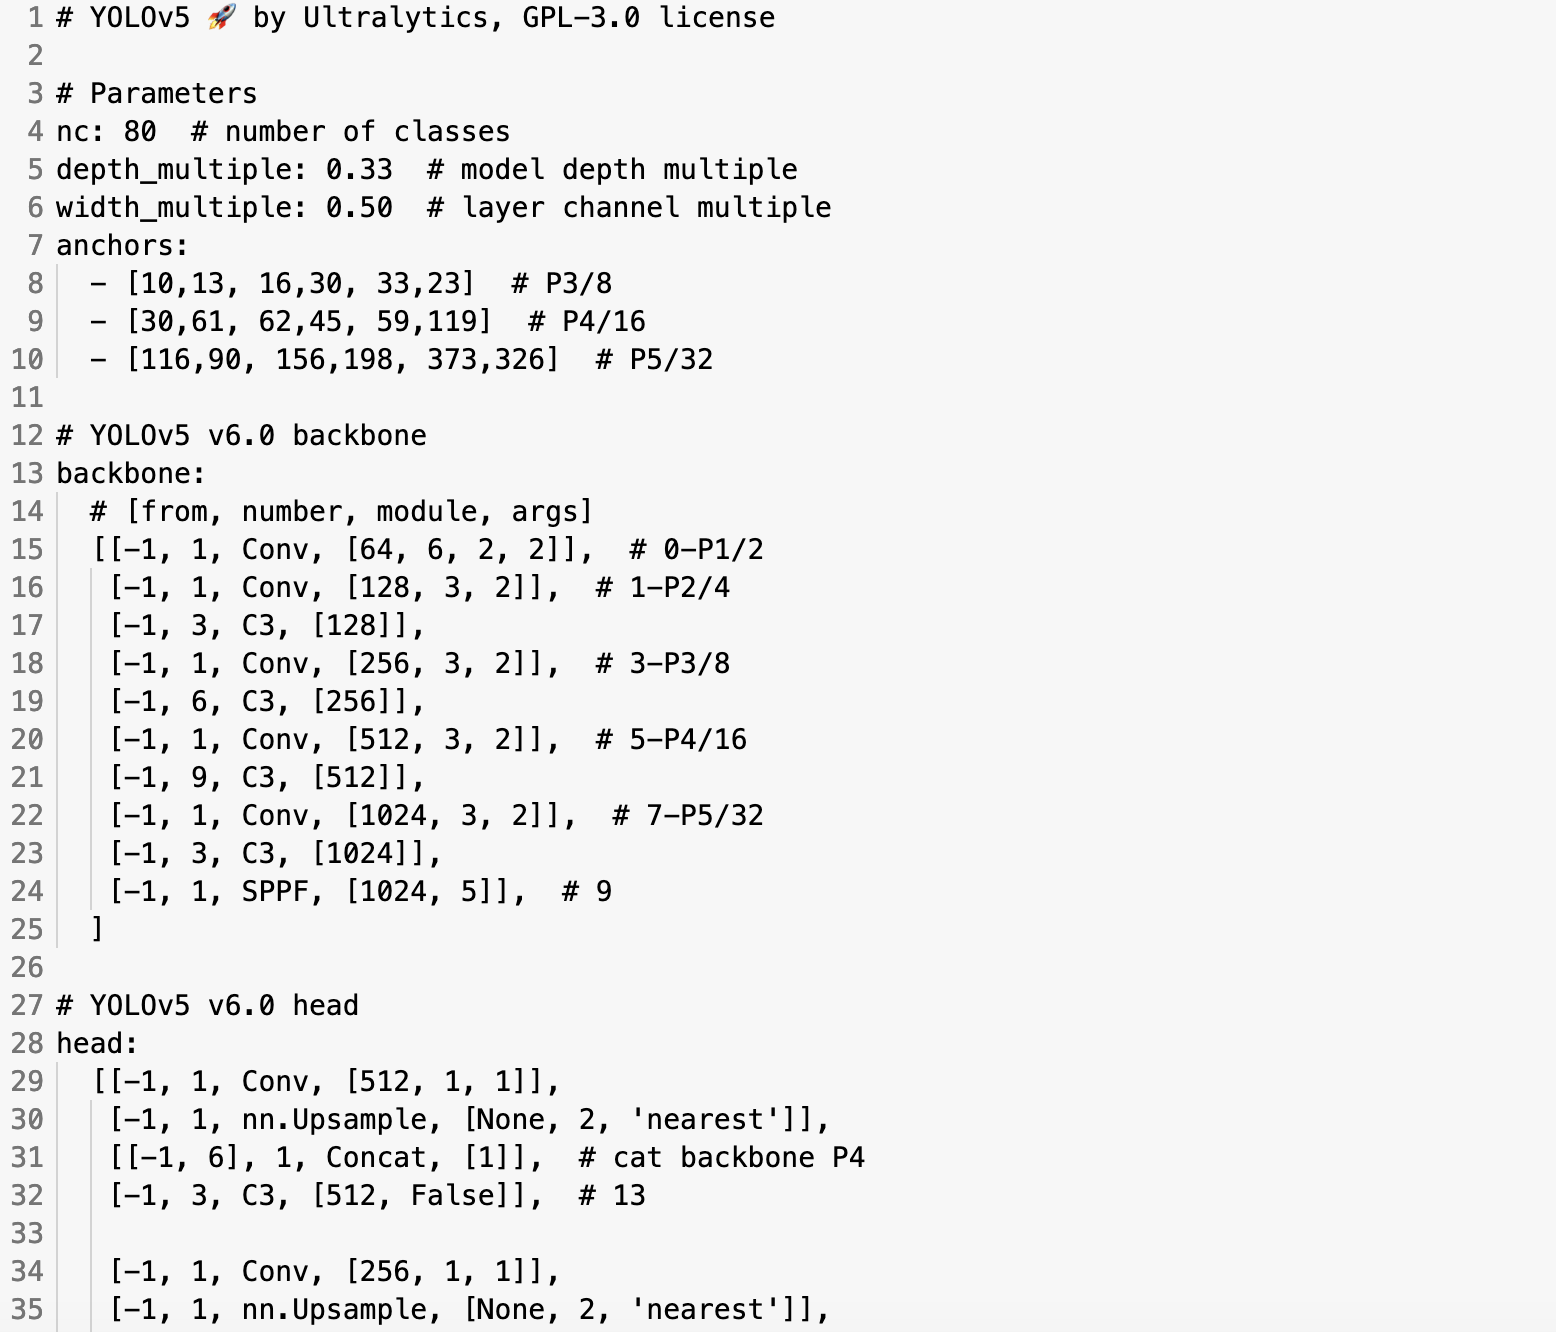

'hyp' flag of the training script points to the configuration file for hyperparameters. We use the default hyperparameters in this example. Example of this file is below...


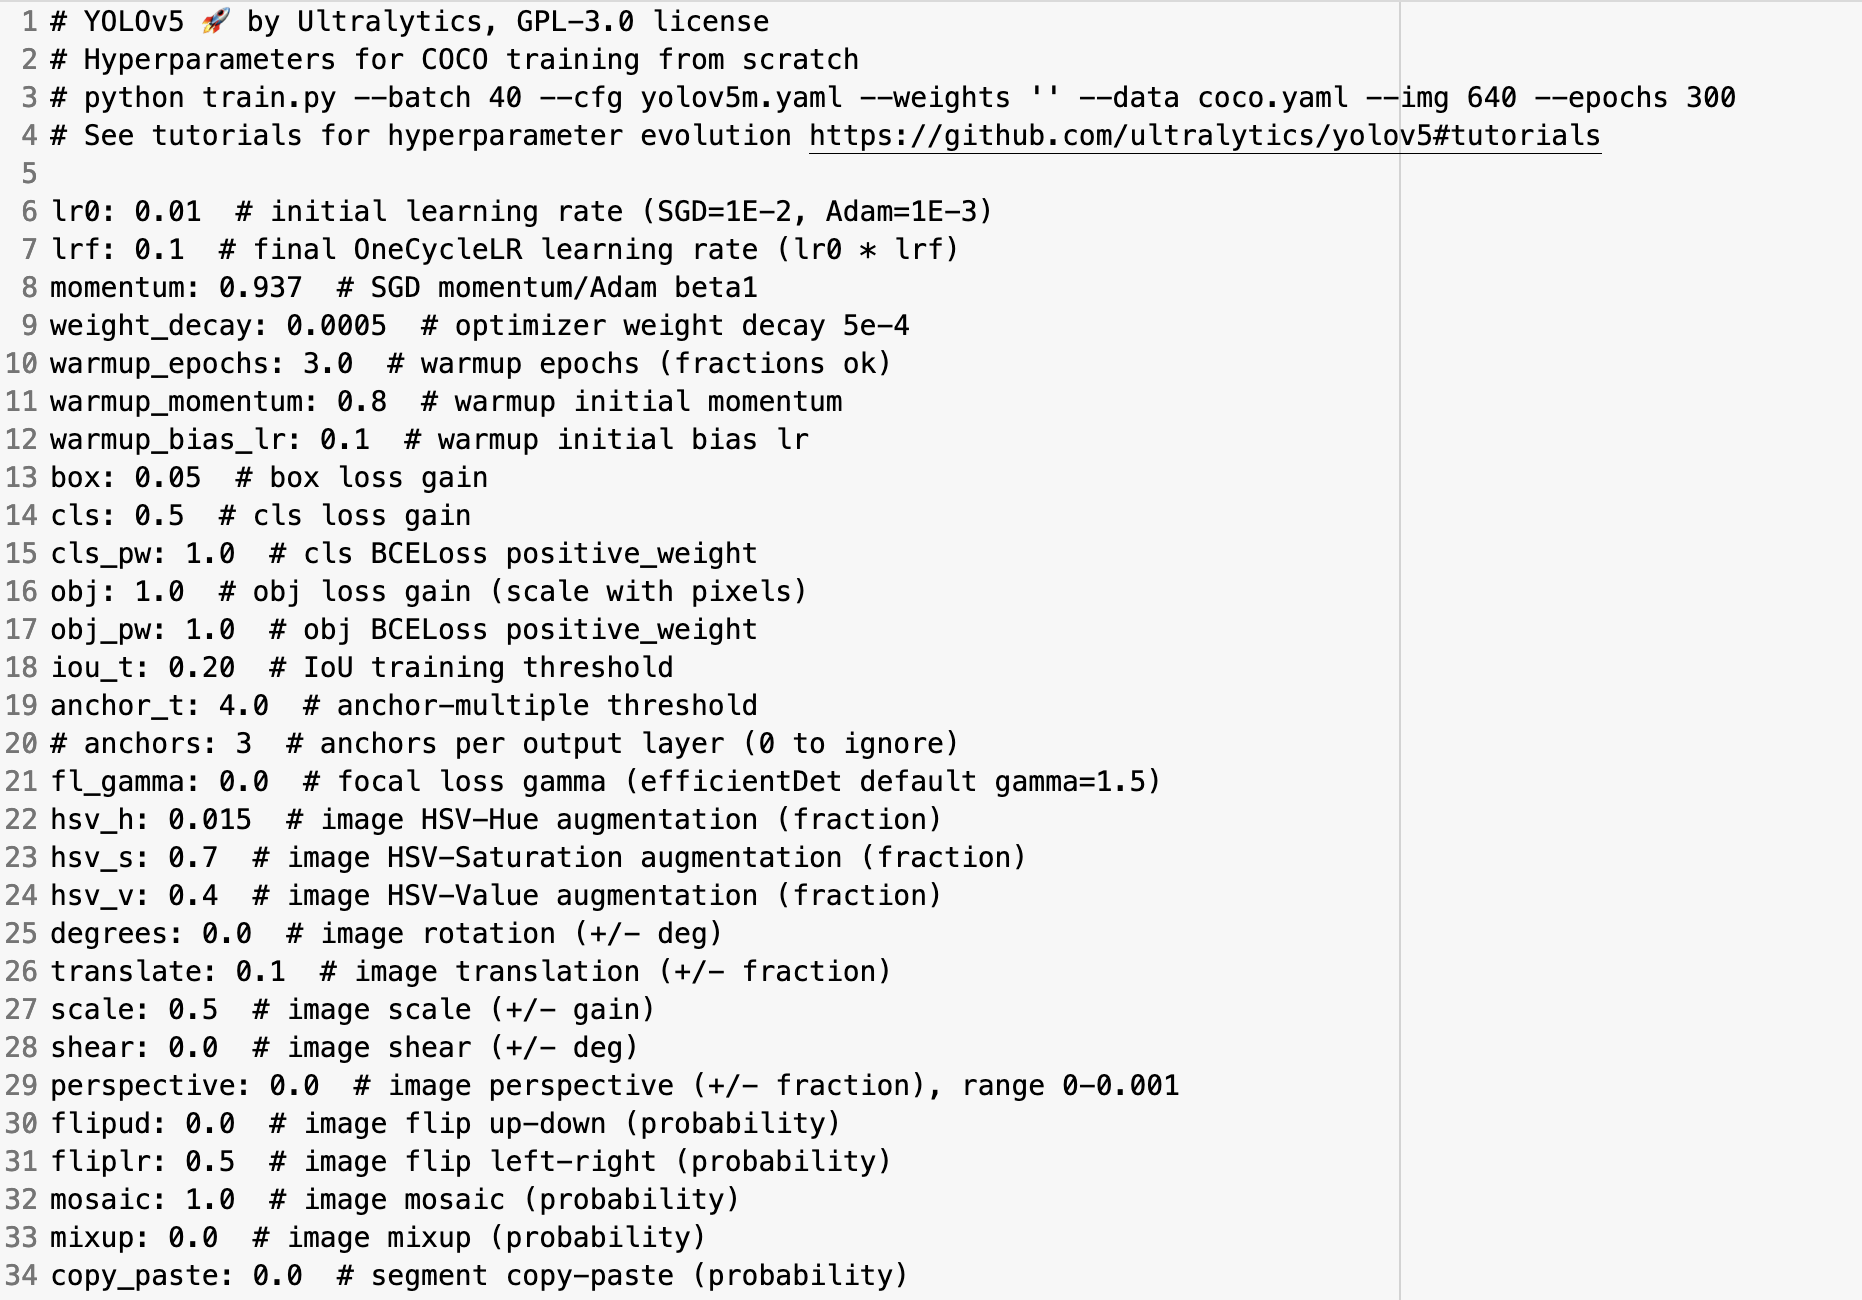

'data' flag points to the configuration file that contains information on the training, testing and validation directories, as well as the information on the number of classes and class names for the model. Example is below ...

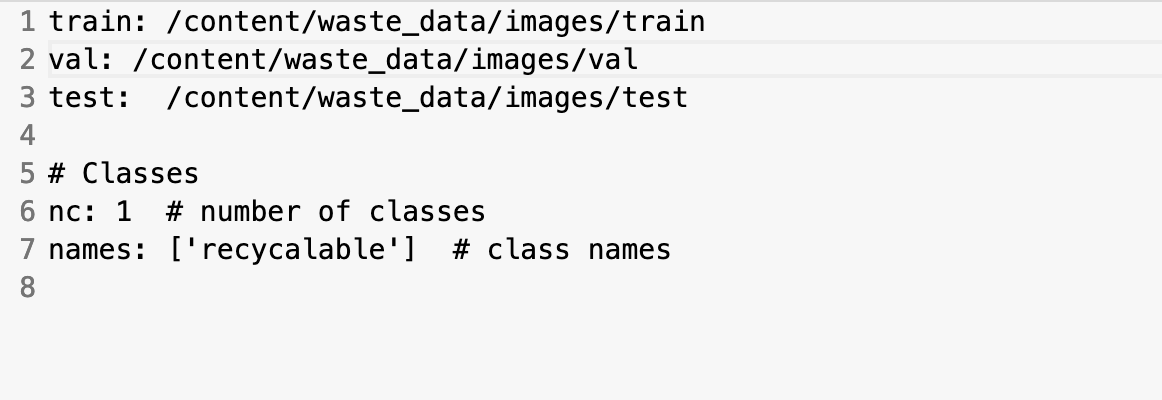

In [ ]:
!python yolov5/train.py --img 700 --cfg yolov5s.yaml --hyp hyp.scratch.yaml --batch 32 --epochs 20 --data waste-class.yaml --weights yolov5s.pt --workers 24 --name yolo_waste_det --device 0

### Predict on test data using the trained YOLO model 

Predict on random images of the web 

In [ ]:
# random photo from the internet 
!python ./yolov5/detect.py  --img 700 --source /content/waste_data/images/random/ --weights yolov5/runs/train/yolo_waste_det/weights/best.pt --conf 0.1 --name yolo_waste_det325

detect: weights=['yolov5/runs/train/yolo_waste_det/weights/best.pt'], source=/content/waste_data/images/random/, imgsz=[700, 700], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=yolo_waste_det325, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-35-ga4fece8 torch 1.9.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/4 /content/waste_data/images/random/285658852.jpg: 544x704 Done. (0.013s)
image 2/4 /content/waste_data/images/random/328057_o03_111120.jpg: 704x704 1 recycalable, Done. (0.009s)
image 3/4 /content/waste_data/images/random/AluCan1,017.jpg: 704x544 1 recycalable, Done. (0.015s)
image 4/4 /content/waste_data/images/random/tr

Visualize results

['yolov5/runs/detect/yolo_waste_det325/285658852.jpg', 'yolov5/runs/detect/yolo_waste_det325/328057_o03_111120.jpg', 'yolov5/runs/detect/yolo_waste_det325/AluCan1,017.jpg', 'yolov5/runs/detect/yolo_waste_det325/trash-talk-5-food-scraps-you-should-not-be-throwing-away.w1456.jpg']


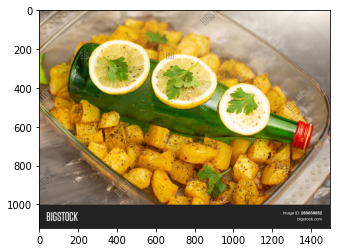

In [ ]:
The detect_dir = "yolov5/runs/detect/yolo_waste_det325"
detect_images = [os.path.join(detect_dir, x) for x in os.listdir(detect_dir)]
print(detect_images)
img_0 = Image.open(detect_images[0])
img_1 = Image.open(detect_images[1])
img_2 = Image.open(detect_images[2])
img_3 = Image.open(detect_images[3])
plt.imshow(np.array(img_0))


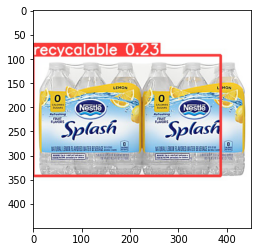

In [ ]:
plt.imshow(np.array(img_1))

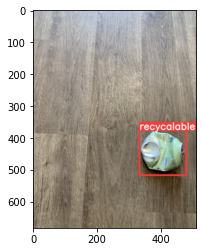

In [ ]:
plt.imshow(np.array(img_2))

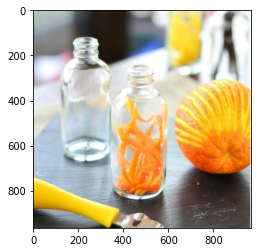

In [ ]:
plt.imshow(np.array(img_3))

Predict on the test directory

In [ ]:
!python ./yolov5/detect.py  --img 700 --source /content/waste_data/images/test/ --weights yolov5/runs/train/yolo_waste_det/weights/best.pt --conf 0.25 --name yolo_waste_det

Visualize results

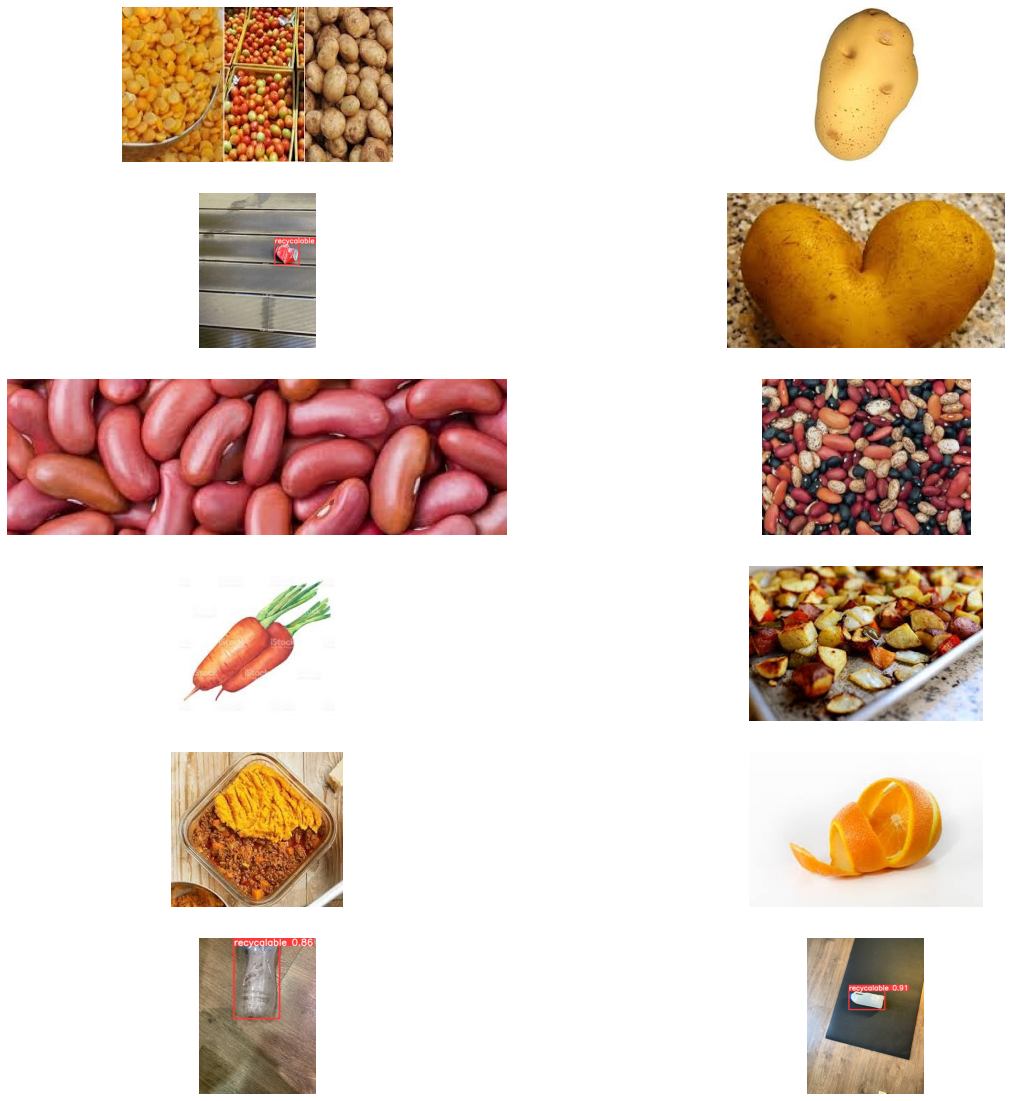

In [ ]:
# Code taken from APCOMP 215 tutorial 04_tutorial_model_compression
image_samples = np.random.randint(0,high=len(detect_images)-1, size=12)

# View some images
fig = plt.figure(figsize=(20,20))
for i,img_idx in enumerate(image_samples):
    axs = fig.add_subplot(6,2,i+1)
    # Read image
    image = cv2.imread(detect_images[img_idx])
    # convert to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')

plt.show()
# Code taken from APCOMP 215 tutorial 04_tutorial_model_compression